In [55]:
from PIL import Image, ImageOps

In [56]:
# all units in mm

PEN_DIAMETER  = 15
GANTRY_LENGTH = 1000
RESOLUTION_X  = PEN_DIAMETER
RESOLUTION_Y  = 1

INPUT_IMAGE = "test3.png"

In [57]:
def debug_display(img):
    debug_img = img.resize((
        int(img.width*RESOLUTION_X*2), 
        int(img.height*RESOLUTION_Y*2)
    ))
    display(debug_img)

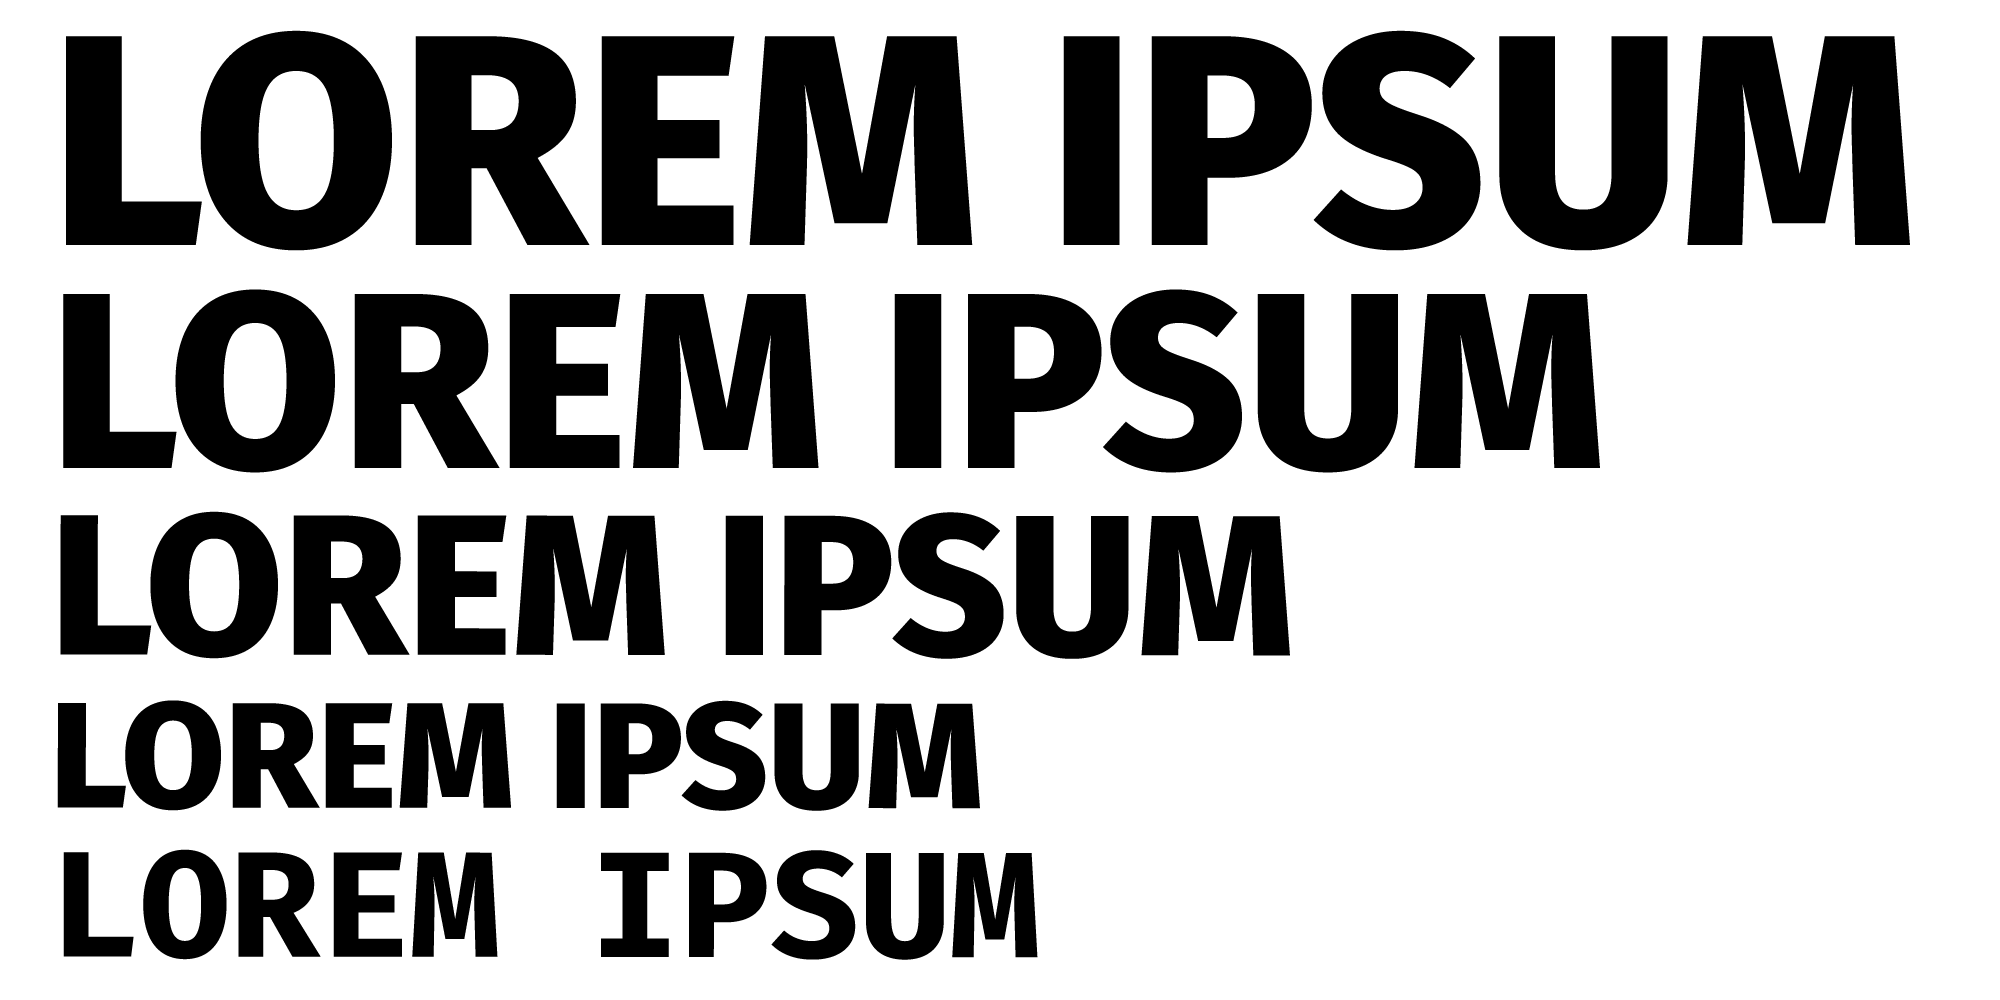

In [58]:
img = Image.open(INPUT_IMAGE)
display(img)

In [59]:
if img.width < img.height:
    img = img.transpose()

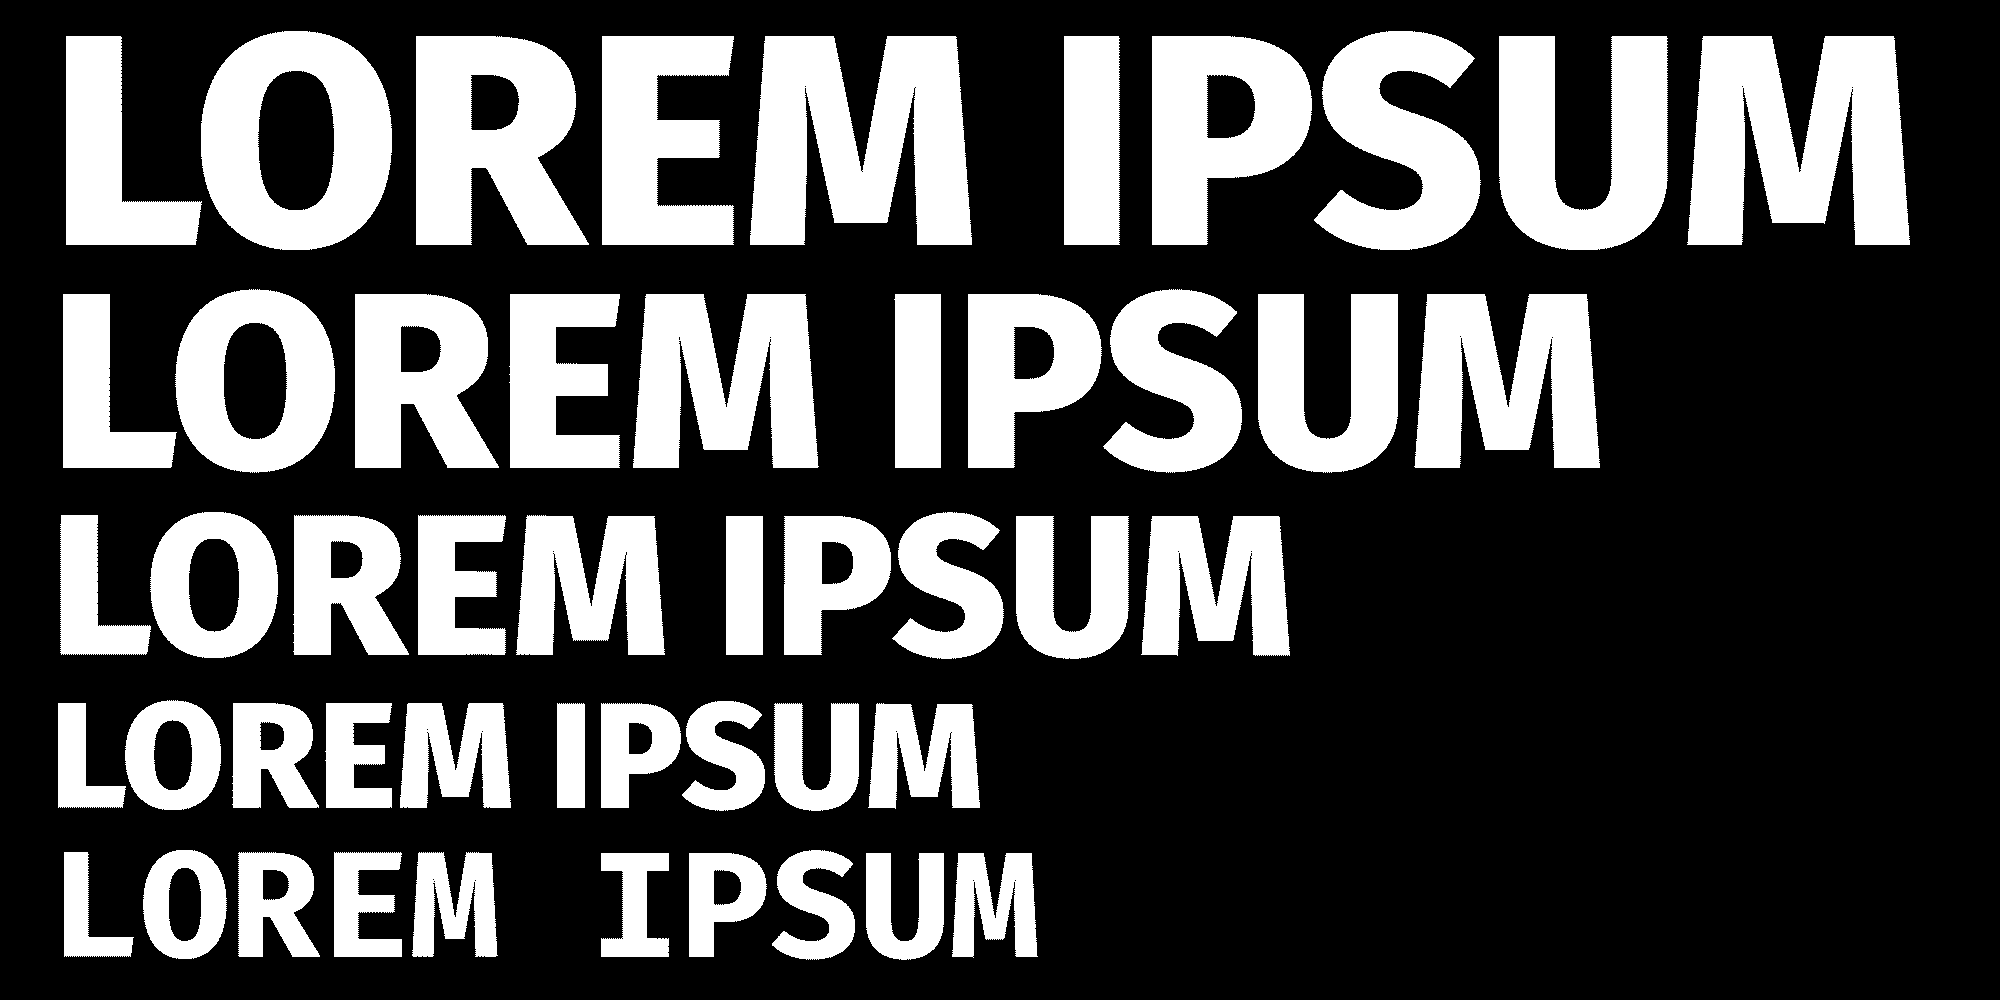

In [60]:
img = img.convert(mode="1")
img = ImageOps.invert(img)
display(img)

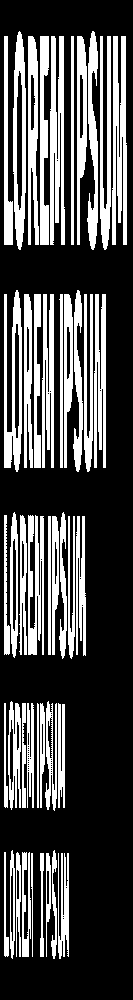

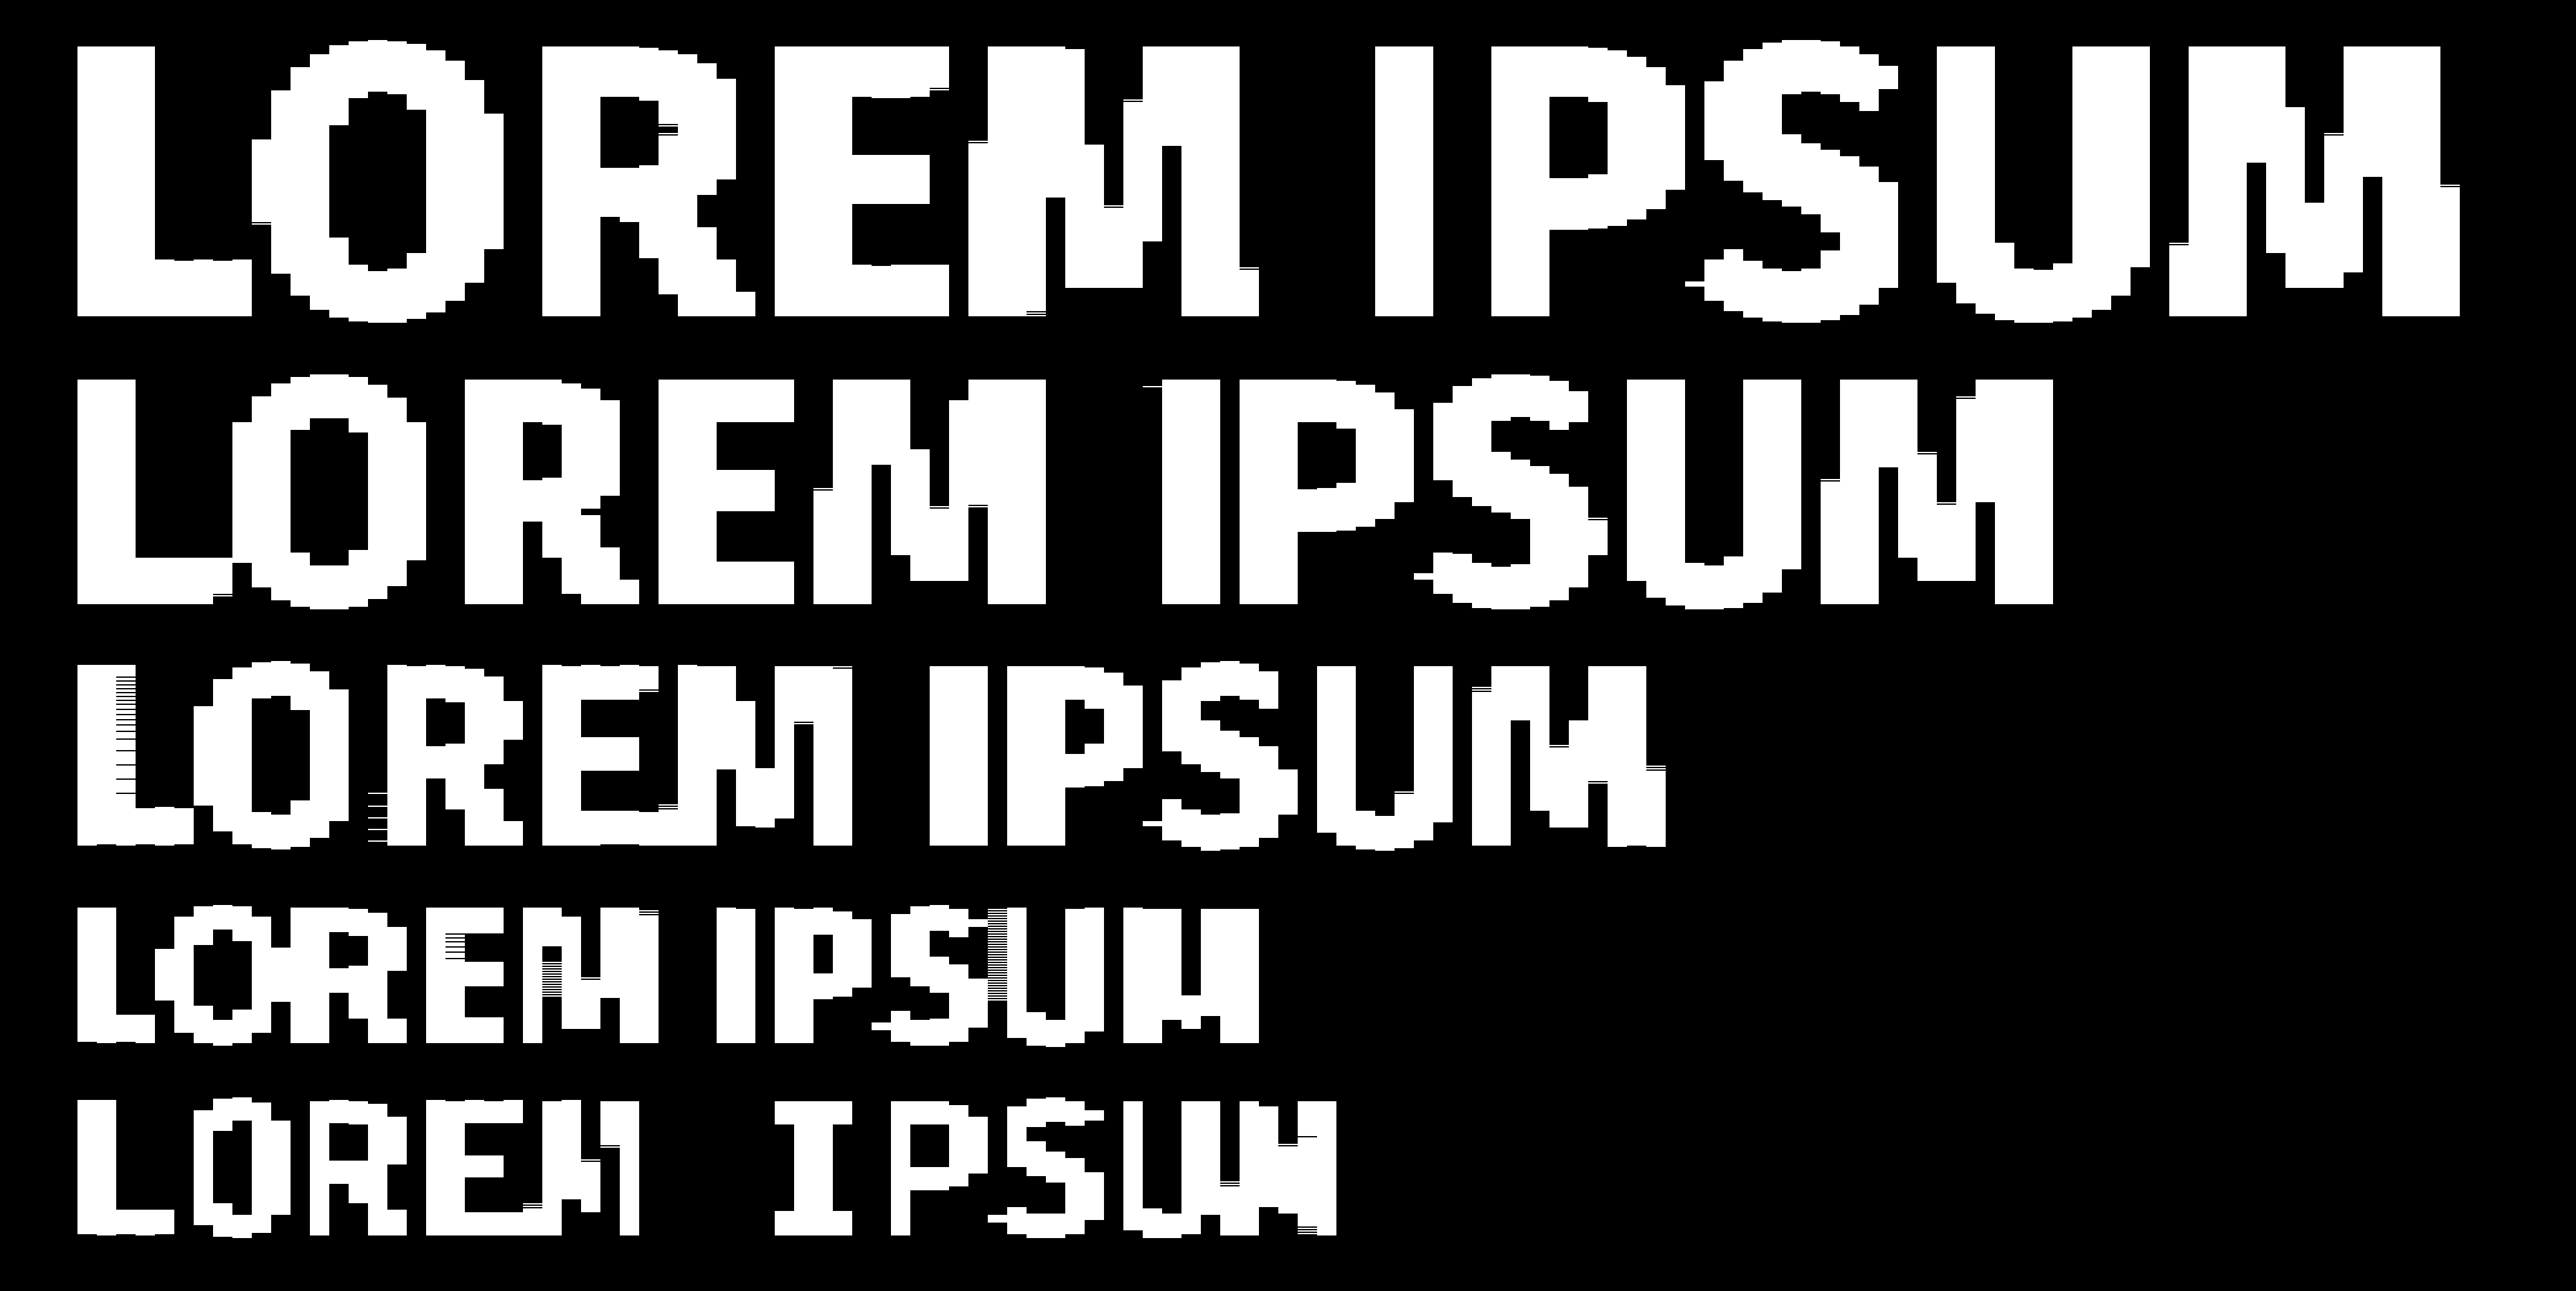

In [61]:
resize_height = GANTRY_LENGTH / RESOLUTION_Y
resize_width = img.width / img.height * GANTRY_LENGTH / RESOLUTION_X

img_resized = img.resize((
    int(resize_width),
    int(resize_height)
))
#), resample=Image.Resampling.LANCZOS)

display(img_resized)
debug_display(img_resized)

In [62]:
segments = []
segment_start = None
for x in range(img_resized.width):
    segments_line = []
    segment_start = None
    for y in range(img_resized.height):
        if segment_start is None:
            if img_resized.getpixel((x, y)) > 0:
                segment_start = [x*RESOLUTION_X, y*RESOLUTION_Y]
        else:
            if img_resized.getpixel((x, y)) == 0:

                segment = [segment_start, [x*RESOLUTION_X, y*RESOLUTION_Y]]
                segment_length = abs(segment[0][1]-segment[1][1])

                if segment_length >= PEN_DIAMETER:
                    segments_line.append(segment)

                segment_start = None
    if len(segments_line) > 0:
        segments.append(segments_line)

if segment_start is not None:
    segments[-1].append([segment_start, [img.width*RESOLUTION_X, img.height*RESOLUTION_Y]])

#for l in segments:
#    for s in l:
#        print(s)
#    print("---")
#print(img_resized.width*RESOLUTION_X, img_resized.height*RESOLUTION_Y)

In [63]:
def write_gcode(segments, filename, params={}):
    
    FEEDRATE_X = 1000
    FEEDRATE_Y = 1000
    FEEDRATE_Z = 1000

    RAISE_DISTANCE = 90
    
    START_CMD           = """
G90 G94                 
G17                    
G21                     
G28         

G1 F{feedrate}
"""
    
    MOVEX_CMD            = """
G1 F{feedrate}
G1 X{x:.4f}
"""

    MOVEY_CMD            = """
G1 F{feedrate}
G1 Y{y:.4f}
"""

    LOWER_CMD           = """
G1 F{feedrate}
G1 Z{z:.4f}
"""

    RAISE_CMD           = """
G1 F{feedrate}
G1 Z{z:.4f}
"""

    END_CMD             = """
G1 F{feedrate}
G1 X0 
G1 X0 Y0 
G92 X0 Y0 Z0 A0       
"""
    
    with open(filename, "w") as f:

        f.write("(ChalkRoll --- date: {} / feedrate: {} {} {})\n".format(
            "?", FEEDRATE_X, FEEDRATE_Y, FEEDRATE_Z
        ))

        for key in params.keys():
            f.write("(info: {} : {})\n".format(key, params[key]))

        f.write(START_CMD.format(
            feedrate=FEEDRATE_X,
        ))
        f.write(RAISE_CMD.format(
            z = RAISE_DISTANCE,
            feedrate=FEEDRATE_Z
        ))

        for line in segments:

            if len(line) == 0:
                continue
            
            first_segment_in_line = line[0]

            f.write(MOVEX_CMD.format(
                x = first_segment_in_line[0][0],
                feedrate=FEEDRATE_X
            ))
            
            for s in line:

                f.write(MOVEY_CMD.format(
                    y = s[0][1],
                    feedrate=FEEDRATE_Y
                ))
    
                f.write(LOWER_CMD.format(
                    z = 0,
                    feedrate=FEEDRATE_Z
                ))
    
                f.write(MOVEY_CMD.format(
                    y = s[1][1],
                    feedrate=FEEDRATE_Y
                ))
    
                f.write(RAISE_CMD.format(
                    z = RAISE_DISTANCE,
                    feedrate=FEEDRATE_Z
                ))

        f.write(END_CMD.format(
            feedrate=FEEDRATE_X
        ))
    

In [64]:


segments_reversed = []
for i in range(len(segments)):
    line = segments[i]
    if i%2==0:
        segments_reversed.append(line)
    else:
        segments_reversed.append(list(reversed([list(reversed(s)) for s in line])))
segments = segments_reversed

write_gcode(segments, "output.gcode")

    